# Tension estimate for non-Gaussian distributions

Cyrille Doux (<doux@lpsc.in2p3.fr>), Marco Raveri (<marco.raveri@unige.it>)

In this notebook we show how to compute the statistical significance of a parameter shift between two experiments, DES Y1 and Planck 18, with the two techniques discussed in 
[Raveri and Doux (2021), arXiv:2105.03324](https://arxiv.org/abs/2105.03324).

In [1]:
# Show plots inline, and load main getdist plot module and samples class
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1
# import libraries:
import sys, os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'../..')))
from getdist import plots, MCSamples
from getdist.gaussian_mixtures import GaussianND
import getdist
getdist.chains.print_load_details = False
import scipy
import matplotlib.pyplot as plt
import IPython
from IPython.display import Markdown
import numpy as np
import seaborn as sns
# import the tensiometer tools that we need:
import tensiometer
from tensiometer import utilities
from tensiometer import gaussian_tension
from tensiometer import mcmc_tension

2023-10-01 20:49:26.730056: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


We start importing the relevant chains. 
The code requires the two chains to be getdist MCSamples objects.
Check [GetDist documentation](https://getdist.readthedocs.io/en/latest/) for example codes of how to import or create them.


In [2]:
# load the samples (remove no burn in since the example chains have already been cleaned):
chains_dir = './../../test_chains/'
# the Planck 2018 TTTEEE chain:
chain_1 = getdist.mcsamples.loadMCSamples(file_root=chains_dir+'Planck18TTTEEE', no_cache=True)
# the DES Y1 3x2 chain:
chain_2 = getdist.mcsamples.loadMCSamples(file_root=chains_dir+'DES', no_cache=True)

Now we compute the parameter difference distribution. 

If we denote $P_1(\theta_1)$ and $P_2(\theta_2)$ as the two independent distributions, then, defining $\Delta\theta \equiv \theta_1 - \theta_2$ then the distribution of parameter differences, $\Delta\theta$ is given by:

\begin{align}
P(\Delta \theta) = \int P_1(\theta)P_2(\theta - \Delta\theta) \, d\theta
\end{align}

Samples from this distribution can be computed as differences between samples of the two distributions. 
This usually results in a large number of samples so, by default, we undersample.
The boost parameter increases the samples retained and should be set to ensure that we have enough samples for later.

In [3]:
# the difference chain:
diff_chain = mcmc_tension.parameter_diff_chain(chain_1, chain_2, boost=4)

Now we do a sanity check plot:

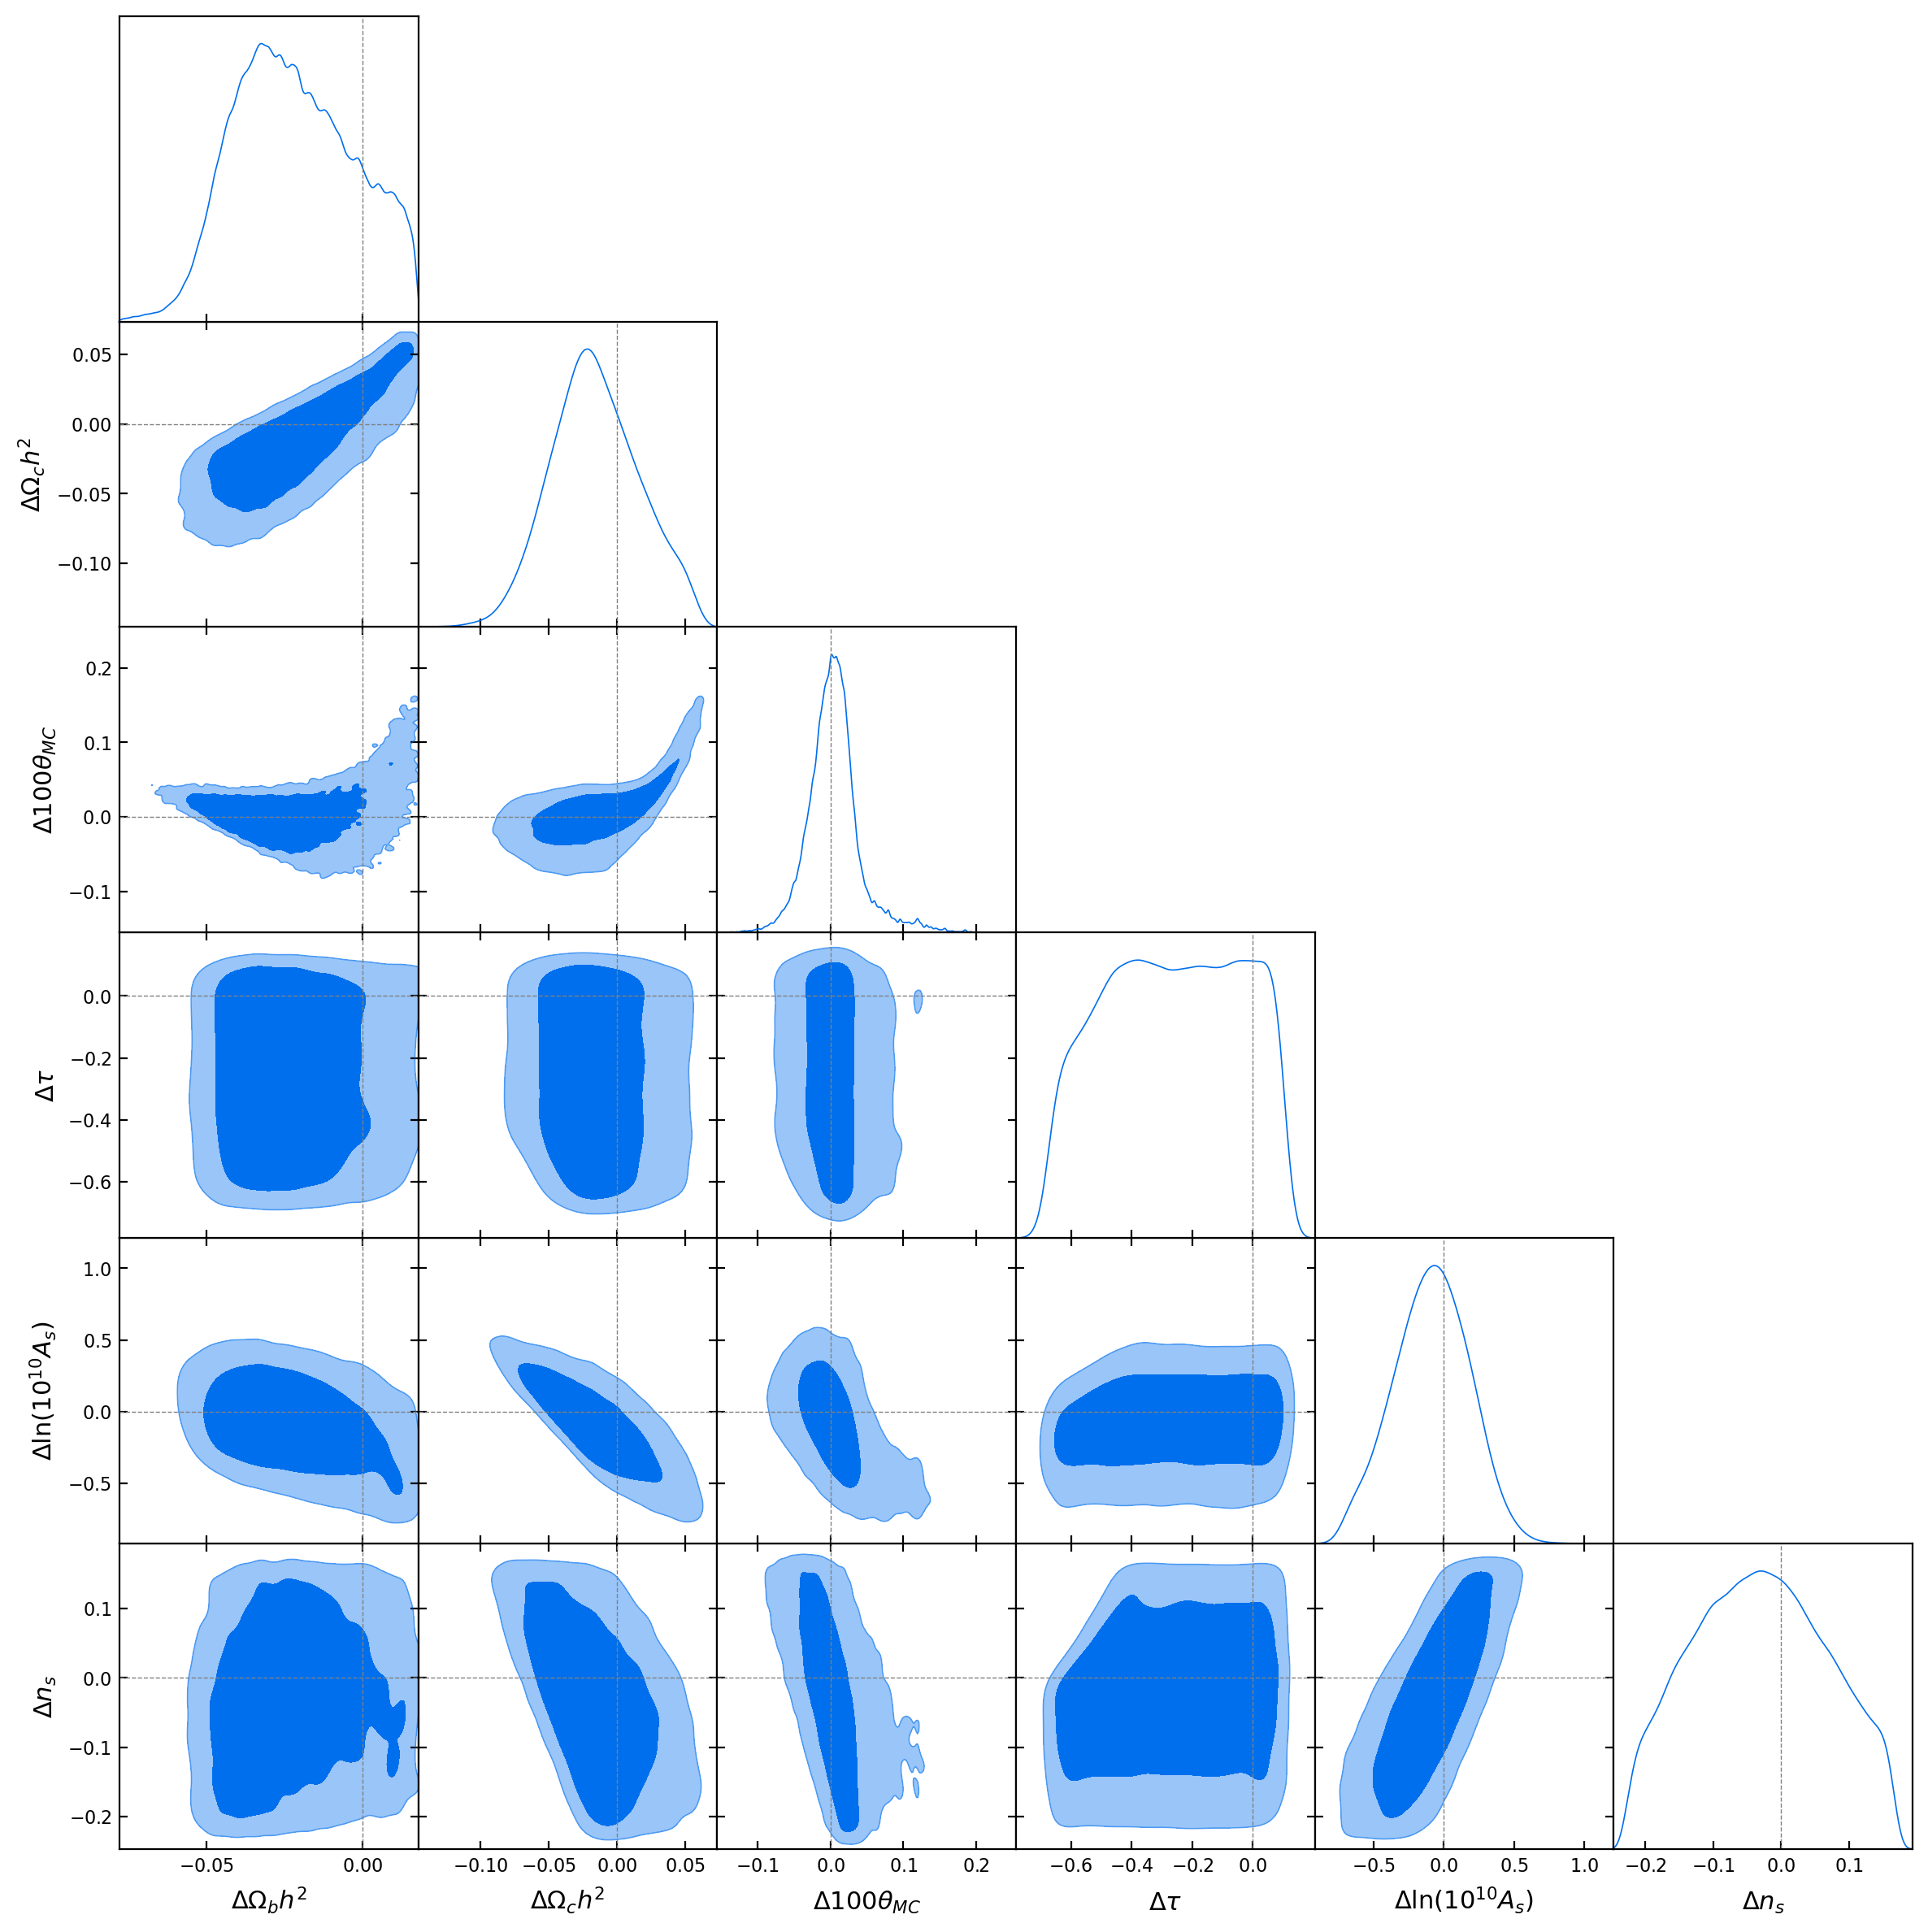

In [4]:
param_names = diff_chain.getParamNames().getRunningNames()
g = plots.get_subplot_plotter()
g.triangle_plot([diff_chain], params=param_names, filled=True, markers={_p:0 for _p in param_names})

Looks non-Gaussian uh? Let's see below how to cope with this!

We need to calculate this integral:

\begin{align}
\Delta \equiv \int_{P(\Delta\theta) > P(0)} P(\Delta\theta) \, d\Delta \theta
\end{align}

which gives the probability mass enclosed in the (full-D) iso-contour that touches the value corresponding to zero shift.

The main problem of this integral is that we have samples from the parameter difference distribution but we cannot associate a probability value to those samples. 
There are two ways to cope with this problem, that we outline below.

# Normalizing flow estimate of parameter shifts:
The code provides a helper function, `tensiometer.mcmc_tension.flow_parameter_shift(diff_chain)`, to create the model, train it and compute the shift significance. We show here how to use it and later how to proceed manually.

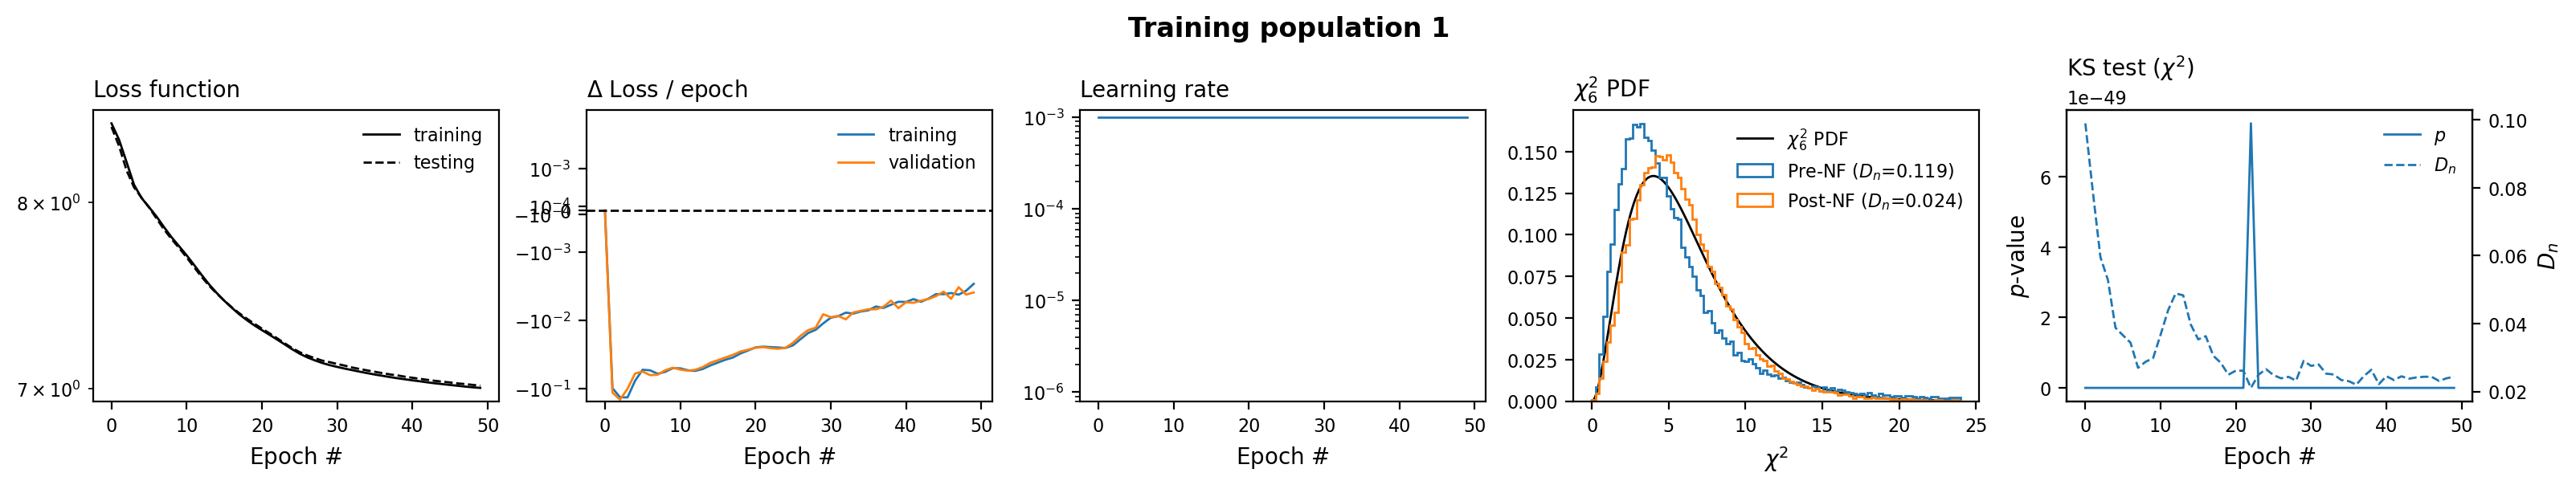

20/20 [==============================] - 10s 516ms/step - loss: 7.0046 - val_loss: 7.0158 - lr: 0.0010
Epoch 51/100
20/20 [==============================] - 7s 342ms/step - loss: 7.0013 - val_loss: 7.0151 - lr: 0.0010
Epoch 52/100
 6/20 [========>.....................] - ETA: 3s - loss: 7.0008

KeyboardInterrupt: 

In [7]:
# the helper function passes all keyword arguments downstream so we can easily set manually all options
kwargs = {
          'feedback': 1
        }

# call the helper function:
tensiometer.mcmc_tension.flow_parameter_shift(diff_chain,   # parameter difference chain
                                              cache_dir=None,  # directory where the trained flow is saved, to save time
                                              root_name='sprob',  # name of the cached flow 
                                              **kwargs
                                              )

We first create the MAF model, with default architecture, but an initial learning rate of 0.01.

In [4]:
diff_flow_callback = tensiometer.mcmc_tension.DiffFlowCallback(diff_chain, feedback=1, learning_rate=0.01)

Building training/test samples
    - 1131315/125701 training/test samples and non-uniform weights.
Building MAF
    - number of MAFs: 12
    - activation: <function asinh at 0x7fa4c2fde290>
    - hidden_units: [12, 12]
Building flow
    - trainable parameters: 4752


We now train the model. To improve convergence, we started with a high learning rate and will use a Keras callback to decrease it when the validation loss is on a plateau.

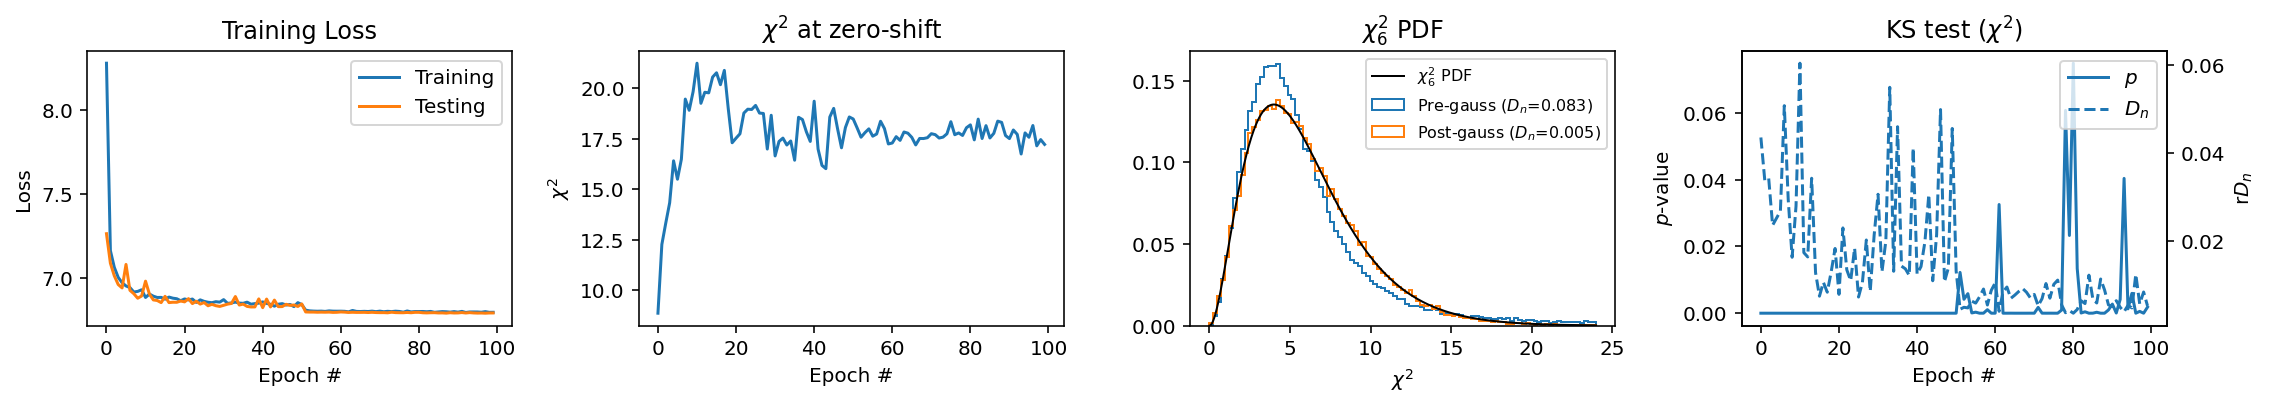

In [5]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
callbacks = [ReduceLROnPlateau()]

batch_size = 8192
epochs = 100
steps_per_epoch = 128

diff_flow_callback.train(batch_size=batch_size, epochs=epochs, steps_per_epoch=steps_per_epoch, callbacks=callbacks)

In [6]:
exact_shift_P_1, exact_shift_low_1, exact_shift_hi_1 = diff_flow_callback.estimate_shift()
print(f'Shift probability considering all parameters = {exact_shift_P_1:.5f} +{exact_shift_hi_1-exact_shift_P_1:.5f} -{exact_shift_P_1-exact_shift_low_1:.5f}')
# turn the result to effective number of sigmas:
print(f'    n_sigma = {utilities.from_confidence_to_sigma(exact_shift_P_1):.3f}')

Shift probability considering all parameters = 0.99668 +0.00018 -0.00019
    n_sigma = 2.936


Note that there is some variance in the result due to initialization. You can repeat the above calculation some times to evaluate the variance.

We can now plot the learned distribution. To do so we draw some samples from the learned distribution and then feed them to getdist plotting:

In [7]:
N = 10000
X_sample = np.array(diff_flow_callback.dist_learned.sample(N))
diff_flow = MCSamples(samples=X_sample, names=param_names, label='Learned distribution')

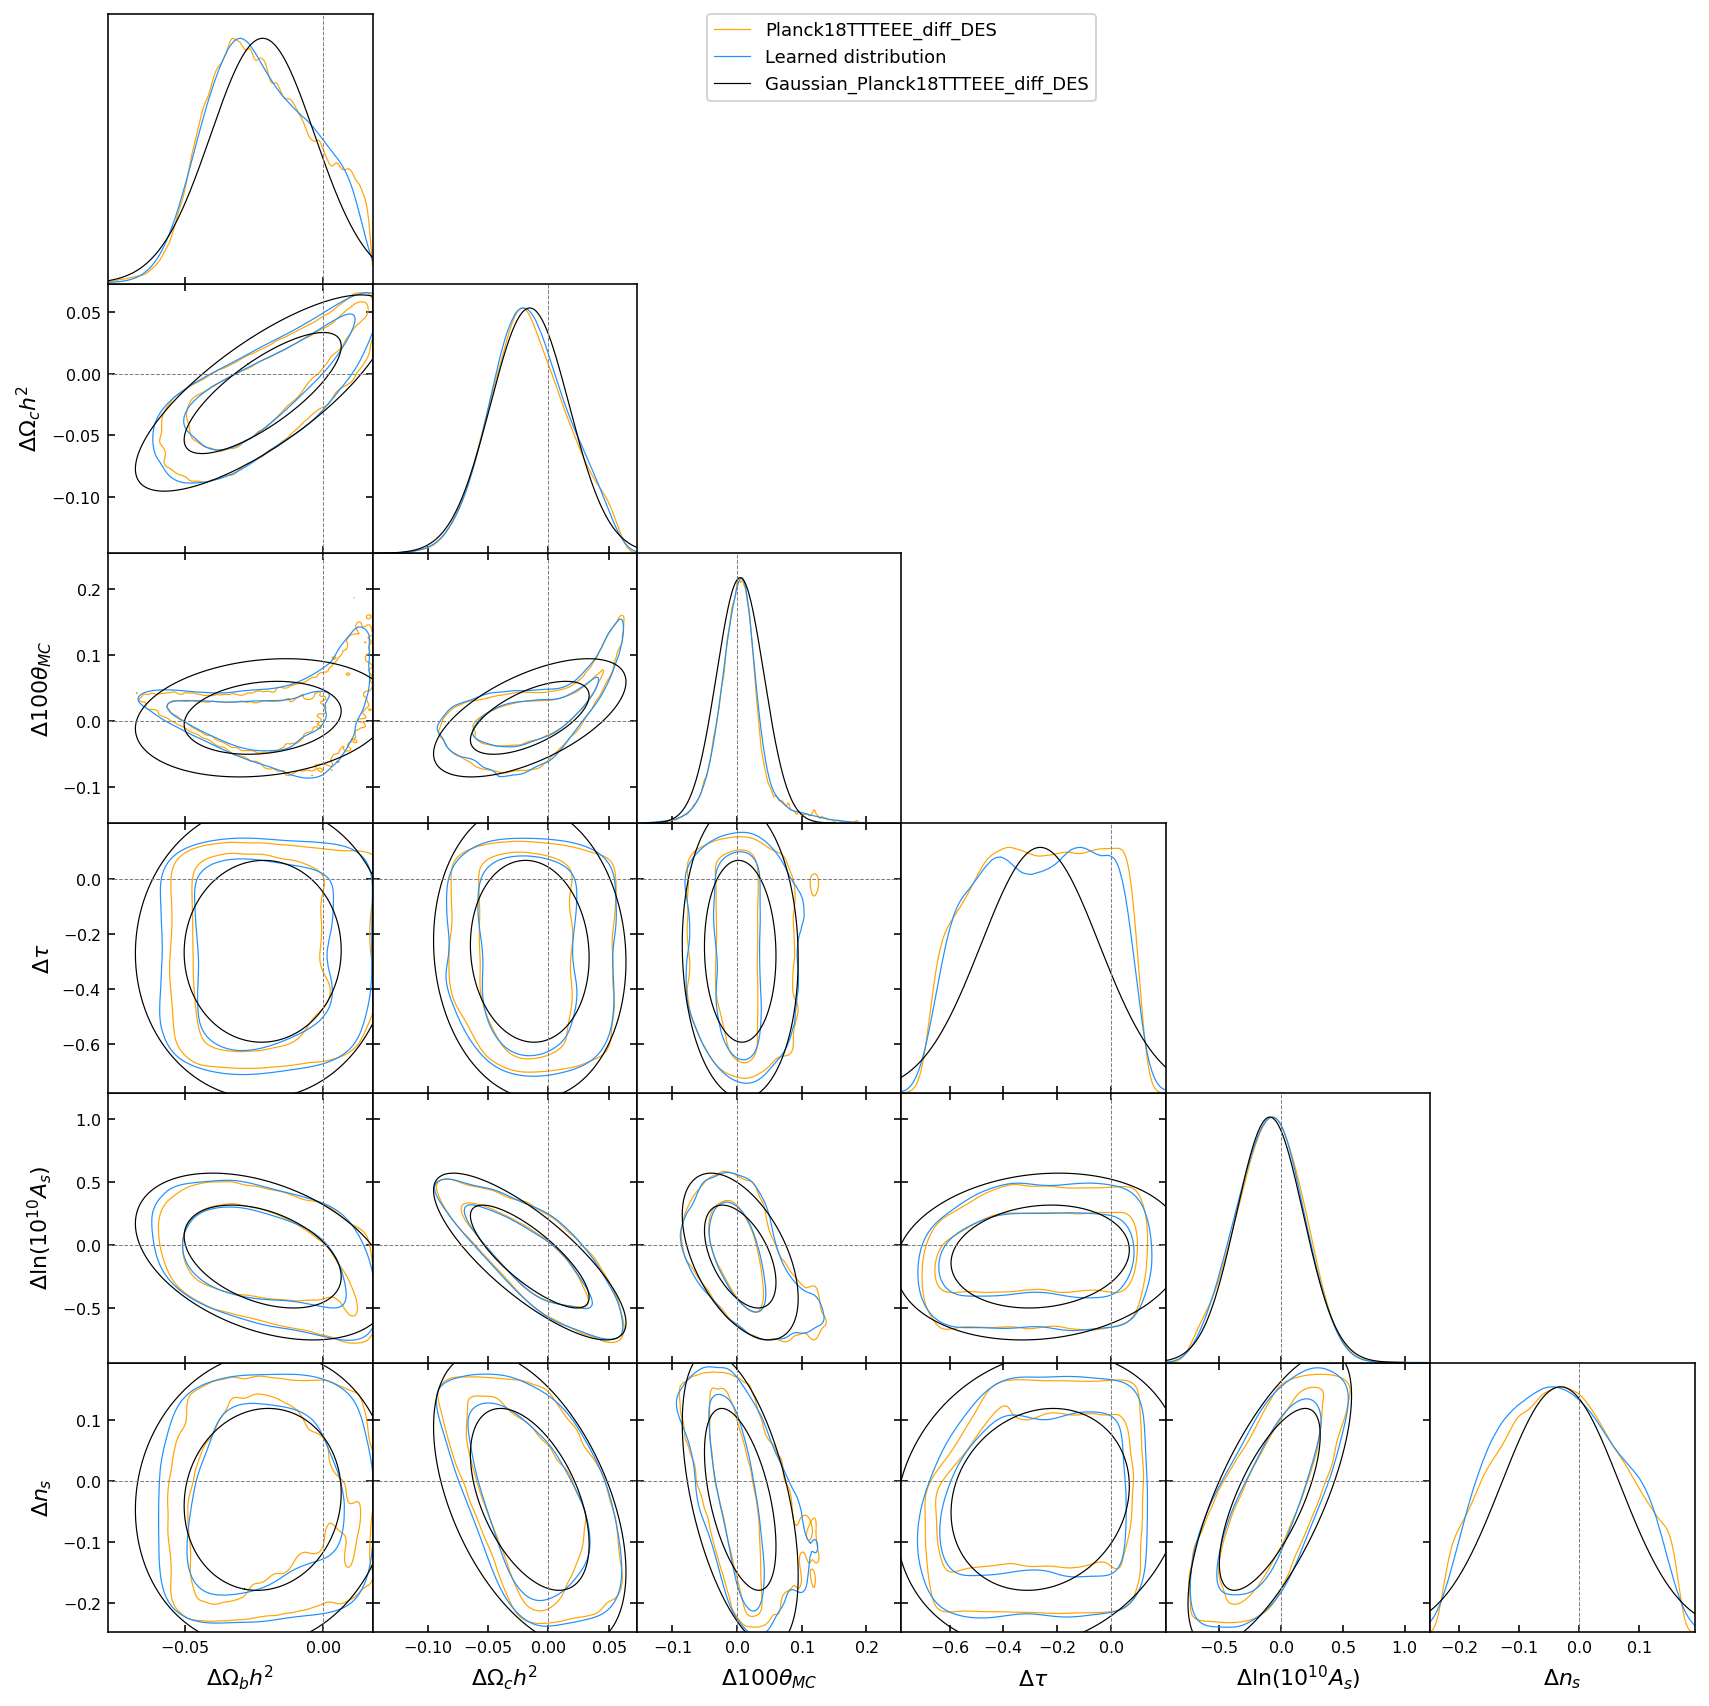

In [8]:
colors=['orange', 'dodgerblue', 'k']
g = plots.get_subplot_plotter()
g.settings.num_plot_contours = 2
gaussian_approx = tensiometer.gaussian_tension.gaussian_approximation(diff_chain)
g.triangle_plot([diff_chain, diff_flow, gaussian_approx], params=param_names,
                filled=False, markers={_p:0 for _p in param_names},
                colors=colors, diag1d_kwargs={'colors':colors})

As we can see the two distributions match astonishingly well, capturing all non-Gaussian feature that we can identify in this plot.

# KDE estimate of parameter shifts:

We first run the KDE algorithm with default settings and high feedback to have a sense of its inner workings:

In [9]:
shift_P, shift_low, shift_hi = mcmc_tension.kde_parameter_shift(diff_chain, feedback=10)
print(f'Shift probability considering all parameters = {shift_P:.5f} +{shift_hi-shift_P:.5f} -{shift_P-shift_low:.5f}')
# turn the result to effective number of sigmas:
print(f'    n_sigma = {utilities.from_confidence_to_sigma(shift_P):.3f}')

Dimension       : 6
N    samples    : 1339087
Neff samples    : 1147971.95
Smoothing scale : [0.056 0.056 0.056 0.056 0.056 0.056]
Building KD-Tree with leafsize = 400
Neighbours elimination
neighbor_elimination: chunk 1
    surviving elements 5540 of 1257016
neighbor_elimination: chunk 2
    surviving elements 4896 of 1257016
neighbor_elimination: chunk 3
    surviving elements 4699 of 1257016
neighbor_elimination: chunk 4
    surviving elements 4626 of 1257016


  0%|          | 0/4589 [00:00<?, ?it/s]

neighbor_elimination: chunk 5
    surviving elements 4589 of 1257016
neighbor_elimination: polishing


100%|##########| 4589/4589 [01:43<00:00, 44.50it/s]


    surviving elements 4495 of 1257016
KDE method: neighbor_elimination
Time taken for KDE calculation: 182.7 (s)
Shift probability considering all parameters = 0.99659 +0.00005 -0.00005
    n_sigma = 2.928


As we can see the algorithm proceeds in two steps, elimination of points that are clearly above the probability of zero shift based on the probability estimate containing just a few nearest points and then brute force polishing of the leftover points. This gets the right answer and takes a fairly reasonable amount of time.

You could try to run this cell with method='brute_force' to see the type of performance improvement that this algorithm achieves.

One key parameter in the estimate of the KDE shift is the smoothing scale for the pdf.
The default choice is the one that minimizes the mean integrated square error (MISE) under assumptions of Gaussianity.

In [10]:
shift_P, shift_low, shift_hi = mcmc_tension.kde_parameter_shift(diff_chain, scale='MISE', feedback=0)
print(f'Shift probability considering all parameters = {shift_P:.5f} +{shift_hi-shift_P:.5f} -{shift_P-shift_low:.5f}')
# turn the result to effective number of sigmas:
print(f'    n_sigma = {utilities.from_confidence_to_sigma(shift_P):.3f}')

Shift probability considering all parameters = 0.99659 +0.00005 -0.00005
    n_sigma = 2.928


But we can try different choices. In particular we could try the asyntotic MISE estimator (AMISE):

In [11]:
shift_P, shift_low, shift_hi = mcmc_tension.kde_parameter_shift(diff_chain, scale='AMISE', feedback=0)
print(f'Shift probability considering all parameters = {shift_P:.5f} +{shift_hi-shift_P:.5f} -{shift_P-shift_low:.5f}')
# turn the result to effective number of sigmas:
print(f'    n_sigma = {utilities.from_confidence_to_sigma(shift_P):.3f}')

Shift probability considering all parameters = 0.99738 +0.00004 -0.00004
    n_sigma = 3.009


which is slightly undersmoothing and hence resulting in a slightly higher tension.

Or we could try the maximum bandwidth that is (by design) oversmoothing:

In [12]:
shift_P, shift_low, shift_hi = mcmc_tension.kde_parameter_shift(diff_chain, scale='MAX', feedback=0)
print(f'Shift probability considering all parameters = {shift_P:.5f} +{shift_hi-shift_P:.5f} -{shift_P-shift_low:.5f}')
# turn the result to effective number of sigmas:
print(f'    n_sigma = {utilities.from_confidence_to_sigma(shift_P):.3f}')

Shift probability considering all parameters = 0.99181 +0.00008 -0.00008
    n_sigma = 2.644


As we can see the MISE smoothing scale achieves a balance between these two. Overestimating the smoothing scale usually results in slightly smaller tensions.

We can now try the adaptive bandwidth:

In [13]:
shift_P, shift_low, shift_hi = mcmc_tension.kde_parameter_shift(diff_chain, scale='BALL', feedback=0)
print(f'Shift probability considering all parameters = {shift_P:.5f} +{shift_hi-shift_P:.5f} -{shift_P-shift_low:.5f}')
# turn the result to effective number of sigmas:
print(f'    n_sigma = {utilities.from_confidence_to_sigma(shift_P):.3f}')

Shift probability considering all parameters = 0.99593 +0.00005 -0.00006
    n_sigma = 2.873


As we can see all results are mostly in agreement with each other and this provides an invaluable cross check of the different calculation techniques.

The number of samples used in the calculation can be changed to make sure that everything is converged and makes sense.
Since all algorithms work in a fairly straightforward way on a laptop we encourage to always try and compare different outputs to make sure the result is sensible.

We now verify that the calculation makes physical sense. We know that a difference between these two results mostly lives in a 2 dimensional parameter space so we can do the calculation there and plot the result.

In this case, since we are in two dimensions we can use the fft algorithm that is sensibly faster.

Shift probability considering two parameters = 0.99769 +0.00004 -0.00004
    n_sigma = 3.047


<Figure size 432x324 with 0 Axes>

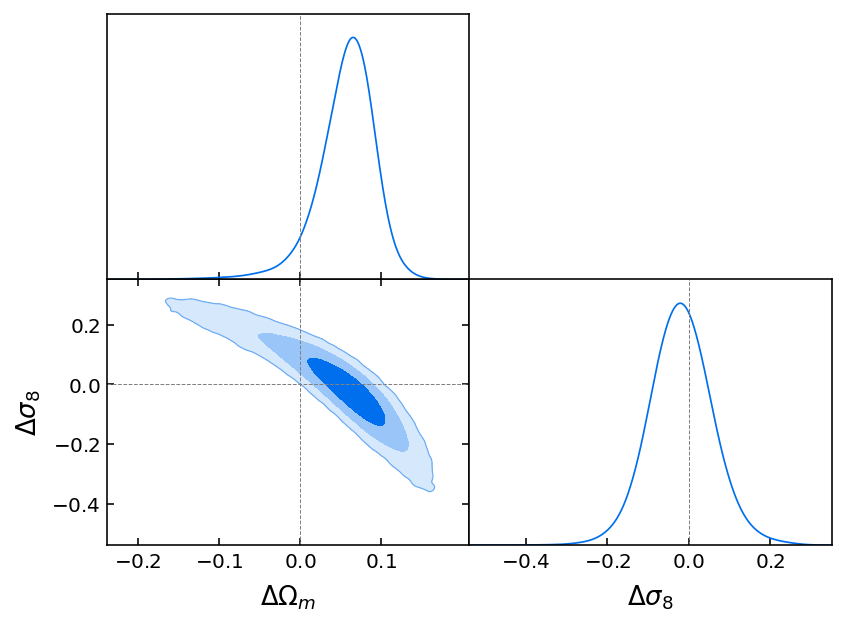

In [14]:
param_names = ['delta_omegam', 'delta_sigma8']
shift_P, shift_low, shift_hi = mcmc_tension.kde_parameter_shift_2D_fft(diff_chain, param_names=param_names, feedback=0)
print(f'Shift probability considering two parameters = {shift_P:.5f} +{shift_hi-shift_P:.5f} -{shift_P-shift_low:.5f}')
# turn the result to effective number of sigmas:
print(f'    n_sigma = {utilities.from_confidence_to_sigma(shift_P):.3f}')
g = plots.get_single_plotter()
diff_chain.updateSettings({'contours': [0.68, 0.95, shift_P]})
g.settings.num_plot_contours = 3
g.triangle_plot(diff_chain, param_names, filled=True, markers={name:0. for name in param_names});